#### OPT-ML Mini project

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import re
import plotly.express as px
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 100)

#### 1. Load initial data files containing experiments and retrieve execution parameters and metrics

(In case you do not have the initial run.txt files go directly to (2))

In [2]:
list_of_optimizers = ['ExtraSGD','SGD', 'Adam', 'ExtraAdam']
root_dir = './backup/tensorboard/'
save_dir = './data/experiments.csv'

#saves execution parameters and metrics for each iteration/epoch of each experiment
metrics = []

#saves all subdirectories containing run.txt files
list_sub_dirs = []
count_exps = 0

# list child dirs recursively
def listdirs(rootdir):
    for path in Path(rootdir).iterdir():
        if path.is_dir():
            list_sub_dirs.append(path)
            listdirs(path)

listdirs(root_dir)


for exp_dir in list_sub_dirs:
    optimizer = exp_dir.parent.name
    
    # parse file name which contains execution parameters
    if optimizer in list_of_optimizers:
        count_exps+=1
        
        lr = re.findall(r'lr[0-9].[0-9]+', exp_dir.name)
        if lr:
            lrG = lrD = lr[0].split('lr')[1]
        else:
            lrG = re.findall(r'lrG[0-9].[0-9]+', exp_dir.name)[0].split('lrG')[1]
            lrD = re.findall(r'lrD[0-9].[0-9]+', exp_dir.name)[0].split('lrD')[1]
    
        bsz = re.findall(r'bsz[0-9]+', exp_dir.name)[0].split('bsz')[1]
        beta = re.findall(r'beta[0-9].[0-9]', exp_dir.name)[0].split('beta')[1]
        
        loss = re.findall(r'wgangp', exp_dir.name)
        if loss:
            loss = 'Wgangp'
        else:
            loss = 'St'
        
        # parse run.txt lines with pattern matching
        with open(exp_dir.joinpath('run.txt'), 'r') as exp_file:
            for line in exp_file:
                if 'FID' in line:
                    line_dict = {}
                    
                    line_dict['optimizer'] = optimizer
                    line_dict['lrG'] = lrG
                    line_dict['lrD'] = lrD
                    line_dict['bsz'] = bsz
                    line_dict['beta'] = beta
                    line_dict['loss'] = loss
                    
                    match_epoch_iter = re.findall(r'\[[0-9]+', line)
                    if match_epoch_iter:
                        line_dict['cur_epoch'] = match_epoch_iter[0][1:]
                        line_dict['cur_iter'] = match_epoch_iter[1][1:]

                    match_max_epoch_iter = re.findall(r'\/[0-9]+', line)
                    if match_max_epoch_iter:
                        line_dict['max_epoch'] = match_max_epoch_iter[0][1:]
                        line_dict['max_iter'] = match_max_epoch_iter[1][1:]

                    is_mean_match = re.findall(r'IS_mean: [0-9]+.[0-9]+', line)
                    if is_mean_match:
                        line_dict['IS_mean'] = is_mean_match[0].split()[1]

                    is_std_match = re.findall(r'IS_std: [0-9]+.[0-9]+', line)
                    if is_std_match:
                        line_dict['IS_std'] = is_std_match[0].split()[1]    

                    fid_match = re.findall(r'FID: [0-9]+.[0-9]+', line)
                    if fid_match:
                        line_dict['FID'] = fid_match[0].split()[1]

                    metrics.append(line_dict)
            
        #print(40*'#')
        print(exp_dir)
        #print(f'optimizer={optimizer},lrG={lrG},lrD={lrD},bsz={bsz},beta={beta}')
        
metrics_df = pd.DataFrame(metrics)
print(f'Total parsed experiments: {count_exps}')

backup\tensorboard\Adam\gan_ep100_lrD0.0001_lrG0.0001_bsz128_imsz64optbeta0.5_wgangp_2022_06_12T21_36_04.866165
backup\tensorboard\Adam\gan_ep100_lrD0.0001_lrG0.0001_bsz128_imsz64optbeta0.92022-06-08
backup\tensorboard\Adam\gan_ep100_lrD0.0001_lrG0.0001_bsz128_imsz64optbeta0.9_wgangp_2022_06_12T21_34_06.208376
backup\tensorboard\Adam\gan_ep100_lrD0.0001_lrG0.0002_bsz128_imsz64optbeta0.52022-06-08T
backup\tensorboard\Adam\gan_ep100_lrD0.0001_lrG0.0002_bsz128_imsz64optbeta0.5_wgangp_2022_06_12T21_36_25.392333
backup\tensorboard\Adam\gan_ep100_lrD0.0001_lrG0.0002_bsz128_imsz64optbeta0.92022-06-09
backup\tensorboard\Adam\gan_ep100_lrD0.0001_lrG0.0002_bsz128_imsz64optbeta0.9_wgangp_2022_06_12T21_34_17.420629
backup\tensorboard\Adam\gan_ep100_lrD0.0001_lrG0.0005_bsz128_imsz64optbeta0.52022-06-08
backup\tensorboard\Adam\gan_ep100_lrD0.0001_lrG0.0005_bsz128_imsz64optbeta0.5_wgangp_2022_06_12T21_36_39.584136
backup\tensorboard\Adam\gan_ep100_lrD0.0001_lrG0.0005_bsz128_imsz64optbeta0.92022-06-09

In [3]:
# create a name for each type of experiment (for grouping/plotting purposes)
metrics_df['name'] = metrics_df['optimizer']+ \
                        '_lrG'+metrics_df['lrG']+ \
                        '_lrD'+metrics_df['lrD']+ \
                        '_beta'+metrics_df['beta'] + \
                        '_bsz'+metrics_df['bsz'] + \
                        '_loss'+metrics_df['loss']

# convert object columns to int type
int_cols = ['bsz', 'cur_epoch', 'cur_iter', 'max_epoch', 'max_iter']
for col in int_cols:
    metrics_df = metrics_df.astype({col:'int'})

# convert object columns to float type
float_cols = ['lrG', 'lrD', 'beta', 'IS_mean', 'IS_std', 'FID']
for col in float_cols:
    metrics_df = metrics_df.astype({col:'float'})
    
# compute number of iterations
metrics_df['iter'] = metrics_df['cur_epoch']*metrics_df['max_iter'] + metrics_df['cur_iter']

# save to csv
metrics_df.to_csv(save_dir, index=False)

metrics_df.head()

,optimizer,lrG,lrD,bsz,beta,loss,cur_epoch,cur_iter,max_epoch,max_iter,IS_mean,IS_std,FID,name,iter
0,Adam,0.0001,0.0001,128,0.5,Wgangp,0,249,100,1583,1.3472,0.0047,276.7057,Adam_lrG0.0001_lrD0.0001_beta0.5_bsz128_lossWg...,249
1,Adam,0.0001,0.0001,128,0.5,Wgangp,0,499,100,1583,1.4700,0.0199,276.1295,Adam_lrG0.0001_lrD0.0001_beta0.5_bsz128_lossWg...,499
2,Adam,0.0001,0.0001,128,0.5,Wgangp,0,749,100,1583,1.6083,0.0151,263.6219,Adam_lrG0.0001_lrD0.0001_beta0.5_bsz128_lossWg...,749
3,Adam,0.0001,0.0001,128,0.5,Wgangp,0,999,100,1583,1.8653,0.0259,262.3246,Adam_lrG0.0001_lrD0.0001_beta0.5_bsz128_lossWg...,999
4,Adam,0.0001,0.0001,128,0.5,Wgangp,0,1249,100,1583,2.6196,0.0578,269.6636,Adam_lrG0.0001_lrD0.0001_beta0.5_bsz128_lossWg...,1249


#### 2. Load execution parameters and metrics for each experiment

In [4]:
load_dir = './data/experiments.csv'
metrics_df = pd.read_csv(load_dir)
display(metrics_df.size)
metrics_df.head()

595920

,optimizer,lrG,lrD,bsz,beta,loss,cur_epoch,cur_iter,max_epoch,max_iter,IS_mean,IS_std,FID,name,iter
0,Adam,0.0001,0.0001,128,0.5,Wgangp,0,249,100,1583,1.3472,0.0047,276.7057,Adam_lrG0.0001_lrD0.0001_beta0.5_bsz128_lossWg...,249
1,Adam,0.0001,0.0001,128,0.5,Wgangp,0,499,100,1583,1.4700,0.0199,276.1295,Adam_lrG0.0001_lrD0.0001_beta0.5_bsz128_lossWg...,499
2,Adam,0.0001,0.0001,128,0.5,Wgangp,0,749,100,1583,1.6083,0.0151,263.6219,Adam_lrG0.0001_lrD0.0001_beta0.5_bsz128_lossWg...,749
3,Adam,0.0001,0.0001,128,0.5,Wgangp,0,999,100,1583,1.8653,0.0259,262.3246,Adam_lrG0.0001_lrD0.0001_beta0.5_bsz128_lossWg...,999
4,Adam,0.0001,0.0001,128,0.5,Wgangp,0,1249,100,1583,2.6196,0.0578,269.6636,Adam_lrG0.0001_lrD0.0001_beta0.5_bsz128_lossWg...,1249


In [5]:
metrics_df.sort_values("FID").groupby("optimizer").first().drop(columns=['max_epoch', 'max_iter', 'name'])

,lrG,lrD,bsz,beta,loss,cur_epoch,cur_iter,IS_mean,IS_std,FID,iter
optimizer,,,,,,,,,,,
Adam,0.0002,0.0002,128,0.9,St,100,450,2.5556,0.0455,10.5606,158750
ExtraAdam,0.0002,0.0002,128,0.9,St,91,197,2.6749,0.0740,10.7904,144250
ExtraSGD,0.0001,0.0005,128,0.5,St,0,1249,1.1663,0.0050,292.2657,1249
SGD,0.0001,0.0005,128,0.5,St,40,1180,1.0192,0.0006,298.0765,64500


#### 3. Create line-plots

1) use case: different optimizers (top3 SGD, Adam top2-beta=0.5 top2-beta=0.9, ExtraAdam top2-beta=0.5 top2-beta=0.9)

In [13]:
# fig = px.line(metrics_df[metrics_df['optimizer']=='SGD'], x="iter", y="FID", color='name')
# fig.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


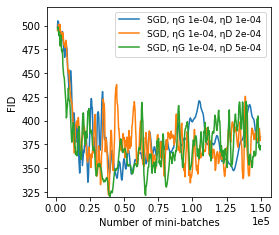

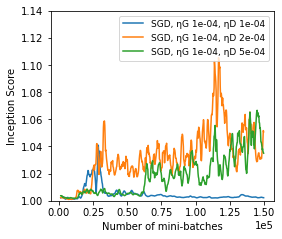

In [6]:
# SGD figures
smoothing = 6
min_threshold = 310
# ALL case
#min_threshold = 400

cols_filter = (metrics_df['optimizer']=='SGD') & \
                (metrics_df['bsz']==128) & \
                (metrics_df['iter']<150000) & \
                (metrics_df['loss']=="St")

sgd_optimizer_df = metrics_df[cols_filter]
sgd_grouped_df = sgd_optimizer_df.groupby('name')['FID'].min().reset_index()
sgd_min_name = sgd_grouped_df[sgd_grouped_df['FID']<min_threshold]['name'].values
sgd_optimizer_df = sgd_optimizer_df[sgd_optimizer_df['name'].isin(sgd_min_name)]

sgd_rolling_metrics_df = sgd_optimizer_df \
                            .groupby('name')[['FID', 'IS_mean']] \
                            .rolling(smoothing) \
                            .mean() \
                            .reset_index() \
                            .drop(columns="name") \
                            .rename(columns={"level_1":"index", "FID":"roll_FID", "IS_mean":"roll_IS_mean"}) \
                            .dropna()

sgd_optimizer_df = pd.merge(sgd_optimizer_df.reset_index(), sgd_rolling_metrics_df, on='index')
sgd_optimizer_df['parameters'] = sgd_optimizer_df['optimizer']+ \
                                ', ηG '+sgd_optimizer_df['lrG'].map(lambda x: "{:.0e}".format(x)).astype(str)+ \
                                ', ηD '+sgd_optimizer_df['lrD'].map(lambda x: "{:.0e}".format(x)).astype(str)

# save FID figure
plt.figure(figsize=(4,3.5))
ax0 = sns.lineplot(data=sgd_optimizer_df, y='roll_FID', x='iter', hue='parameters')
ax0.legend_.set_title(None)
ax0.legend(loc='upper right')
ax0.set(ylim=(320, 520))
plt.setp(ax0.get_legend().get_texts(), fontsize='9')
ax0.set_xlabel("Number of mini-batches")
ax0.set_ylabel("FID")
#ax0.set_title("Best training parameters\n in terms of min FID for SGD");
ax0.ticklabel_format(style='sci', scilimits=(0,0), axis='x')
plt.savefig('./figures/SGD_FID.png', bbox_inches='tight', dpi=100)
plt.savefig('./figures/SGD_FID.eps', bbox_inches='tight', format='eps')

# save IS_mean figure
plt.figure(figsize=(4,3.5))
ax0 = sns.lineplot(data=sgd_optimizer_df, y='roll_IS_mean', x='iter', hue='parameters')
ax0.legend_.set_title(None)
ax0.legend(loc='upper right')
ax0.set(ylim=(1, 1.14))
plt.setp(ax0.get_legend().get_texts(), fontsize='9')
ax0.set_xlabel("Number of mini-batches")
ax0.set_ylabel("Inception Score")
#ax0.set_title("Best training parameters\n in terms of min FID for SGD");
ax0.ticklabel_format(style='sci', scilimits=(0,0), axis='x')
plt.savefig('./figures/SGD_IS.png', bbox_inches='tight', dpi=100)
plt.savefig('./figures/SGD_IS.eps', bbox_inches='tight', format='eps')


# # save ALL FID figure
# plt.figure(figsize=(10,6))
# ax0 = sns.lineplot(data=sgd_optimizer_df, y='roll_FID', x='iter', hue='parameters')
# ax0.legend_.set_title(None)
# ax0.legend(loc='upper right')
# ax0.set(ylim=(320, 520))
# plt.setp(ax0.get_legend().get_texts(), fontsize='9')
# ax0.set_xlabel("Number of mini-batches")
# ax0.set_ylabel("FID")
# #ax0.set_title("Training parameters for SGD");
# ax0.ticklabel_format(style='sci', scilimits=(0,0), axis='x')
# plt.savefig('./figures/ALL_SGD_FID.png', bbox_inches='tight', dpi=100)
# plt.savefig('./figures/ALL_SGD_FID.eps', bbox_inches='tight', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


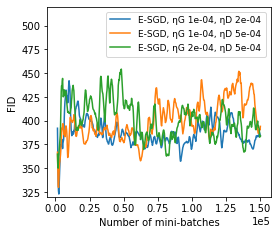

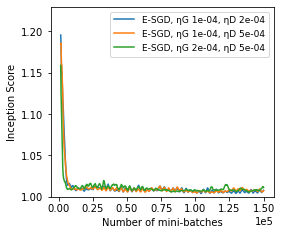

In [7]:
# ExtraSGD figures
smoothing = 6
min_threshold = 315
# ALL case
#min_threshold = 400

cols_filter = (metrics_df['optimizer']=='ExtraSGD') & \
                (metrics_df['bsz']==128) & \
                (metrics_df['iter']<150000) & \
                (metrics_df['loss']=="St")

sgd_optimizer_df = metrics_df[cols_filter]
sgd_grouped_df = sgd_optimizer_df.groupby('name')['FID'].min().reset_index()
sgd_min_name = sgd_grouped_df[sgd_grouped_df['FID']<min_threshold]['name'].values
sgd_optimizer_df = sgd_optimizer_df[sgd_optimizer_df['name'].isin(sgd_min_name)]

sgd_rolling_metrics_df = sgd_optimizer_df \
                            .groupby('name')[['FID', 'IS_mean']] \
                            .rolling(smoothing) \
                            .mean() \
                            .reset_index() \
                            .drop(columns="name") \
                            .rename(columns={"level_1":"index", "FID":"roll_FID", "IS_mean":"roll_IS_mean"}) \
                            .dropna()

sgd_optimizer_df = pd.merge(sgd_optimizer_df.reset_index(), sgd_rolling_metrics_df, on='index')
sgd_optimizer_df['parameters'] = 'E-SGD'+ \
                                ', ηG '+sgd_optimizer_df['lrG'].map(lambda x: "{:.0e}".format(x)).astype(str)+ \
                                ', ηD '+sgd_optimizer_df['lrD'].map(lambda x: "{:.0e}".format(x)).astype(str)

# save FID figure
plt.figure(figsize=(4,3.5))
ax0 = sns.lineplot(data=sgd_optimizer_df, y='roll_FID', x='iter', hue='parameters')
ax0.legend_.set_title(None)
ax0.legend(loc='upper right')
ax0.set(ylim=(320, 520))
plt.setp(ax0.get_legend().get_texts(), fontsize='9')
ax0.set_xlabel("Number of mini-batches")
ax0.set_ylabel("FID")
#ax0.set_title("Best training parameters\n in terms of min FID for ExtraSGD");
ax0.ticklabel_format(style='sci', scilimits=(0,0), axis='x')
plt.savefig('./figures/Extra_SGD_FID.png', bbox_inches='tight', dpi=100)
plt.savefig('./figures/Extra_SGD_FID.eps', bbox_inches='tight', format='eps')

# save IS_mean figure
plt.figure(figsize=(4,3.5))
ax0 = sns.lineplot(data=sgd_optimizer_df, y='roll_IS_mean', x='iter', hue='parameters')
ax0.legend_.set_title(None)
ax0.legend(loc='upper right')
ax0.set(ylim=(1, 1.23))
plt.setp(ax0.get_legend().get_texts(), fontsize='9')
ax0.set_xlabel("Number of mini-batches")
ax0.set_ylabel("Inception Score")
#ax0.set_title("Best training parameters\n in terms of min FID for ExtraSGD");
ax0.ticklabel_format(style='sci', scilimits=(0,0), axis='x')
plt.savefig('./figures/Extra_SGD_IS.png', bbox_inches='tight', dpi=100)
plt.savefig('./figures/Extra_SGD_IS.eps', bbox_inches='tight', format='eps')

# # save ALL FID figure
# plt.figure(figsize=(10,6))
# ax0 = sns.lineplot(data=sgd_optimizer_df, y='roll_FID', x='iter', hue='parameters')
# ax0.legend_.set_title(None)
# ax0.legend(loc='upper right')
# ax0.set(ylim=(310, 550))
# plt.setp(ax0.get_legend().get_texts(), fontsize='9')
# ax0.set_xlabel("Number of mini-batches")
# ax0.set_ylabel("FID")
# #ax0.set_title("Training parameters for SGD");
# ax0.ticklabel_format(style='sci', scilimits=(0,0), axis='x')
# plt.savefig('./figures/ALL_Extra_SGD_FID.png', bbox_inches='tight', dpi=100)
# plt.savefig('./figures/ALL_Extra_SGD_FID.eps', bbox_inches='tight', format='eps')

In [36]:
# fig = px.line(metrics_df[metrics_df['optimizer']=='Adam'], x="iter", y="FID", color='name')
# fig.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


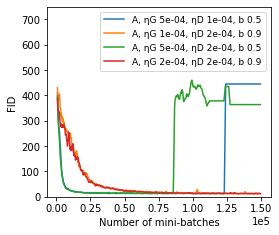

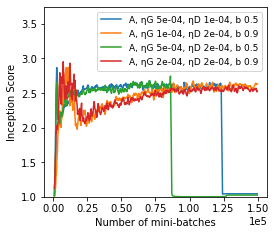

In [8]:
# Adam figures
smoothing = 4
min_threshold = 11.1
#top-10 case
#min_threshold = 13.7

cols_filter = (metrics_df['optimizer']=='Adam') & \
                (metrics_df['bsz']==128) & \
                (metrics_df['iter']<150000) & \
                (metrics_df['loss']=="St")

adam_optimizer_df = metrics_df[cols_filter]
adam_grouped_df = adam_optimizer_df.groupby('name')['FID'].min().reset_index()
adam_min_name = adam_grouped_df[adam_grouped_df['FID']<min_threshold]['name'].values
adam_optimizer_df = adam_optimizer_df[adam_optimizer_df['name'].isin(adam_min_name)]

adam_rolling_metrics_df = adam_optimizer_df \
                            .groupby('name')[['FID', 'IS_mean']] \
                            .rolling(smoothing) \
                            .mean() \
                            .reset_index() \
                            .drop(columns="name") \
                            .rename(columns={"level_1":"index", "FID":"roll_FID", "IS_mean":"roll_IS_mean"}) \
                            .dropna()

adam_optimizer_df = pd.merge(adam_optimizer_df.reset_index(), adam_rolling_metrics_df, on='index')

adam_optimizer_df['parameters'] = 'A'+ \
                                ', ηG '+adam_optimizer_df['lrG'].map(lambda x: "{:.0e}".format(x)).astype(str)+ \
                                ', ηD '+adam_optimizer_df['lrD'].map(lambda x: "{:.0e}".format(x)).astype(str)+ \
                                ', b '+adam_optimizer_df['beta'].astype(str)

# save FID figure
plt.figure(figsize=(4,3.5))
ax1 = sns.lineplot(data=adam_optimizer_df, y='roll_FID', x='iter', hue='parameters')
ax1.legend_.set_title(None)
ax1.legend(loc='upper right')
ax1.set(ylim=(0, 750))
plt.setp(ax1.get_legend().get_texts(), fontsize='9')
ax1.set_xlabel("Number of mini-batches")
ax1.set_ylabel("FID")
#ax1.set_title("Best training parameters per beta-1\n in terms of min FID for Adam");
ax1.ticklabel_format(style='sci', scilimits=(0,0), axis='x')
plt.savefig('./figures/Adam_FID.png', bbox_inches='tight', dpi=100)
plt.savefig('./figures/Adam_FID.eps', bbox_inches='tight', format='eps')

# save IS_mean figure
plt.figure(figsize=(4,3.5))
ax1 = sns.lineplot(data=adam_optimizer_df, y='roll_IS_mean', x='iter', hue='parameters')
ax1.legend_.set_title(None)
ax1.legend(loc='upper right')
ax1.set(ylim=(1, 3.75))
plt.setp(ax1.get_legend().get_texts(), fontsize='9')
ax1.set_xlabel("Number of mini-batches")
ax1.set_ylabel("Inception Score")
#ax1.set_title("Best training parameters per beta-1\n in terms of min FID for Adam");
ax1.ticklabel_format(style='sci', scilimits=(0,0), axis='x')
plt.savefig('./figures/Adam_IS.png', bbox_inches='tight', dpi=100)
plt.savefig('./figures/Adam_IS.eps', bbox_inches='tight', format='eps')

# # save Top 10 FID figure
# plt.figure(figsize=(10,6))
# ax1 = sns.lineplot(data=adam_optimizer_df, y='roll_FID', x='iter', hue='parameters')
# ax1.legend_.set_title(None)
# ax1.legend(loc='upper right')
# ax1.set(ylim=(0, 750))
# plt.setp(ax1.get_legend().get_texts(), fontsize='9')
# ax1.set_xlabel("Number of mini-batches")
# ax1.set_ylabel("FID")
# #ax1.set_title("Top-10 training parameters in terms of min FID for Adam");
# ax1.ticklabel_format(style='sci', scilimits=(0,0), axis='x')
# plt.savefig('./figures/TOP10_Adam_FID.png', bbox_inches='tight', dpi=100)
# plt.savefig('./figures/TOP10_Adam_FID.eps', bbox_inches='tight', format='eps')

In [37]:
# fig = px.line(metrics_df[metrics_df['optimizer']=='ExtraAdam'], x="iter", y="FID", color='name')
# fig.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


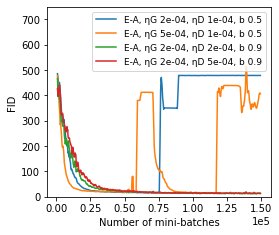

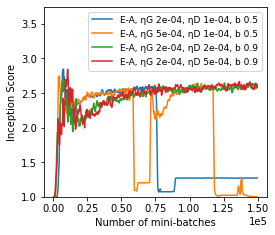

In [9]:
# ExtraAdam figures
smoothing = 4
min_threshold_1 = 12
min_threshold_2 = 14.4
#top-10 case
# min_threshold_1 = 16
# min_threshold_2 = 16

cols_filter = (metrics_df['optimizer']=='ExtraAdam') & \
                (metrics_df['bsz']==128) & \
                (metrics_df['iter']<150000) & \
                (metrics_df['loss']=="St")

extra_adam_optimizer_df = metrics_df[cols_filter]
extra_adam_grouped_df = extra_adam_optimizer_df.groupby('name')[['FID', 'beta']].min('FID').reset_index()
col_filter = ((extra_adam_grouped_df['FID']<min_threshold_1) & (extra_adam_grouped_df['beta']==0.9)) | \
                ((extra_adam_grouped_df['FID']<min_threshold_2) & (extra_adam_grouped_df['beta']==0.5))
extra_adam_min_name = extra_adam_grouped_df[col_filter]['name'].values
extra_adam_optimizer_df = extra_adam_optimizer_df[extra_adam_optimizer_df['name'].isin(extra_adam_min_name)]

extra_adam_rolling_metrics_df = extra_adam_optimizer_df \
                            .groupby('name')[['FID', 'IS_mean']] \
                            .rolling(smoothing) \
                            .mean() \
                            .reset_index() \
                            .drop(columns="name") \
                            .rename(columns={"level_1":"index", "FID":"roll_FID", "IS_mean":"roll_IS_mean"}) \
                            .dropna()

extra_adam_optimizer_df = pd.merge(extra_adam_optimizer_df.reset_index(), extra_adam_rolling_metrics_df, on='index')

extra_adam_optimizer_df['parameters'] = 'E-A'+ \
                                ', ηG '+extra_adam_optimizer_df['lrG'].map(lambda x: "{:.0e}".format(x)).astype(str)+ \
                                ', ηD '+extra_adam_optimizer_df['lrD'].map(lambda x: "{:.0e}".format(x)).astype(str)+ \
                                ', b '+extra_adam_optimizer_df['beta'].astype(str)

# save FID figure
plt.figure(figsize=(4,3.5))
ax2 = sns.lineplot(data=extra_adam_optimizer_df, y='roll_FID', x='iter', hue='parameters')
ax2.legend_.set_title(None)
ax2.legend(loc='upper right')
ax2.set(ylim=(0, 750))
plt.setp(ax2.get_legend().get_texts(), fontsize='9');
ax2.set_xlabel("Number of mini-batches")
ax2.set_ylabel("FID")
#ax2.set_title("Best training parameters per beta-1\n in terms of min FID for ExtraAdam");
ax2.ticklabel_format(style='sci', scilimits=(0,0), axis='x')
plt.savefig('./figures/ExtraAdam_FID.png', bbox_inches='tight', dpi=100)
plt.savefig('./figures/ExtraAdam_FID.eps', bbox_inches='tight', format='eps')

# save IS_mean figure
plt.figure(figsize=(4,3.5))
ax2 = sns.lineplot(data=extra_adam_optimizer_df, y='roll_IS_mean', x='iter', hue='parameters')
ax2.legend_.set_title(None)
ax2.legend(loc='upper right')
ax2.set(ylim=(1, 3.75))
plt.setp(ax2.get_legend().get_texts(), fontsize='9');
ax2.set_xlabel("Number of mini-batches")
ax2.set_ylabel("Inception Score")
#ax2.set_title("Best training parameters per beta-1\n in terms of min FID for ExtraAdam");
ax2.ticklabel_format(style='sci', scilimits=(0,0), axis='x')
plt.savefig('./figures/ExtraAdam_IS.png', bbox_inches='tight', dpi=100)
plt.savefig('./figures/ExtraAdam_IS.eps', bbox_inches='tight', format='eps')

# # save Top 10 FID figure
# plt.figure(figsize=(10,6))
# ax2 = sns.lineplot(data=extra_adam_optimizer_df, y='roll_FID', x='iter', hue='parameters')
# ax2.legend_.set_title(None)
# ax2.legend(loc='upper right')
# ax2.set(ylim=(0, 800))
# plt.setp(ax2.get_legend().get_texts(), fontsize='9');
# ax2.set_xlabel("Number of mini-batches")
# ax2.set_ylabel("FID")
# ax2.set_title("Top-10 training parameters in terms of min FID for ExtraAdam");
# ax2.ticklabel_format(style='sci', scilimits=(0,0), axis='x')
# plt.savefig('./figures/TOP10_ExtraAdam_FID.png', bbox_inches='tight', dpi=100)
# plt.savefig('./figures/TOP10_ExtraAdam_FID.eps', bbox_inches='tight', format='eps')

2) use case: compare top 2 adam vs extra adam regradless of beta

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


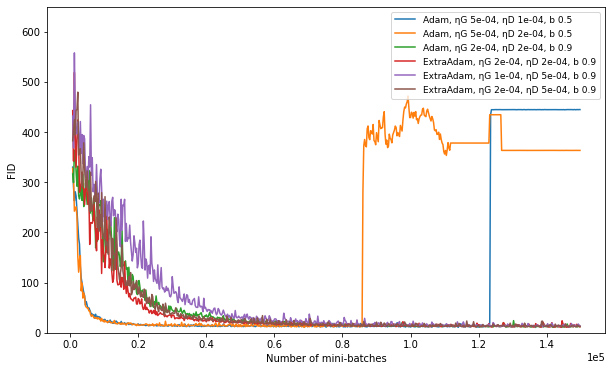

In [10]:
smoothing = 4
# min_adam_threshold = 10.85
# min_eadam_threshold = 12
min_adam_threshold = 10.9
min_eadam_threshold = 12.04

cols_filter = ((metrics_df['optimizer']=='ExtraAdam') | (metrics_df['optimizer']=='Adam')) & \
                (metrics_df['bsz']==128) & \
                (metrics_df['iter']<150000) & \
                (metrics_df['loss']=="St")

avse_df = metrics_df[cols_filter]

avse_grouped_df = avse_df.groupby('name').agg(optimizer=('optimizer', 'first'),
                                              min_fid=('FID', 'min'),
                                              beta=('beta', 'first')).reset_index()

cols_filter = ((avse_grouped_df['min_fid']<min_adam_threshold) & (avse_grouped_df['optimizer']=='Adam')) | \
                ((avse_grouped_df['min_fid']<min_eadam_threshold) & (avse_grouped_df['optimizer']=='ExtraAdam'))
avse_min_name = avse_grouped_df[cols_filter]['name'].values
avse_df = avse_df[avse_df['name'].isin(avse_min_name)]

avse_rolling_metrics_df = avse_df \
                            .groupby('name')[['FID', 'IS_mean']] \
                            .rolling(smoothing) \
                            .mean() \
                            .reset_index() \
                            .drop(columns="name") \
                            .rename(columns={"level_1":"index", "FID":"roll_FID", "IS_mean":"roll_IS_mean"}) \
                            .dropna()

avse_df = pd.merge(avse_df.reset_index(), avse_rolling_metrics_df, on='index')

avse_df['parameters'] = avse_df['optimizer']+ \
                                ', ηG '+avse_df['lrG'].map(lambda x: "{:.0e}".format(x)).astype(str)+ \
                                ', ηD '+avse_df['lrD'].map(lambda x: "{:.0e}".format(x)).astype(str)+ \
                                ', b '+avse_df['beta'].astype(str)

# save FID figure
plt.figure(figsize=(10,6))
sns_ax = sns.lineplot(data=avse_df, y='FID', x='iter', hue='parameters')
sns_ax.legend_.set_title(None)
sns_ax.legend(loc='upper right')
plt.setp(sns_ax.get_legend().get_texts(), fontsize='9');
#sns_ax.set_title("Best training parameters in terms of min FID for Adam and ExtraAdam");
sns_ax.set(ylim=(0, 650))
#sns_ax.set_title("Top-3 Adam Vs. Top-3 ExtraAdam");
sns_ax.set_xlabel("Number of mini-batches");
sns_ax.set_ylabel("FID");
sns_ax.ticklabel_format(style='sci', scilimits=(0,0), axis='x')
plt.savefig('./figures/TOP3_ADAM_VS_TOP3_ExtraAdam_FID.png', bbox_inches='tight', dpi=200)
plt.savefig('./figures/TOP3_ADAM_VS_TOP3_ExtraAdam_FID.eps', bbox_inches='tight', format='eps')

3) use case: compare loss

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


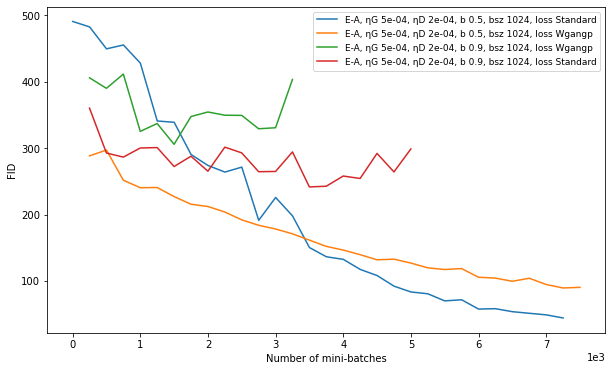

In [11]:
#gan_ep100_lrD0.0002_lrG0.0005_bsz1024_imsz64optbeta0.9_wgangp_

cols_filter = (metrics_df['optimizer']=='ExtraAdam') & \
                (metrics_df['bsz']==1024) & \
                (metrics_df['lrD']==0.0002) & \
                (metrics_df['lrG']==0.0005) & \
                (metrics_df['iter']<7500)

loss_df = metrics_df[cols_filter]
loss_df["loss"] = loss_df["loss"].replace({"St": "Standard"})

loss_df['parameters'] = "E-A"+ \
                                ', ηG '+loss_df['lrG'].map(lambda x: "{:.0e}".format(x)).astype(str)+ \
                                ', ηD '+loss_df['lrD'].map(lambda x: "{:.0e}".format(x)).astype(str)+ \
                                ', b '+loss_df['beta'].astype(str)+ \
                                ', bsz '+loss_df['bsz'].astype(str)+ \
                                ', loss '+loss_df['loss'].astype(str)


# save FID figure
plt.figure(figsize=(10,6))
sns_ax = sns.lineplot(data=loss_df, y='FID', x='iter', hue='parameters')
sns_ax.legend_.set_title(None)
sns_ax.legend(loc='upper right')
plt.setp(sns_ax.get_legend().get_texts(), fontsize='9');
#sns_ax.set_title("Wgangp vs. Standard loss for ExtraAdam with batch size 1024");
sns_ax.set_xlabel("Number of mini-batches");
sns_ax.set_ylabel("FID");
sns_ax.ticklabel_format(style='sci', scilimits=(0,0), axis='x')
plt.savefig('./figures/wgangp_vs_standard_ExtraAdam_FID.png', bbox_inches='tight', dpi=200)
plt.savefig('./figures/wgangp_vs_standard_ExtraAdam_FID.eps', bbox_inches='tight', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


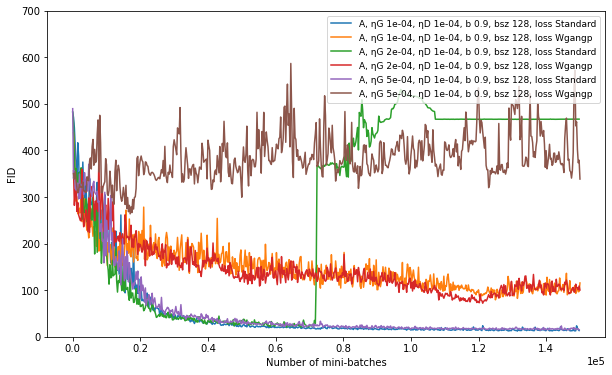

In [12]:
#gan_ep100_lrD0.0002_lrG0.0005_bsz1024_imsz64optbeta0.9_wgangp_

# cols_filter = (metrics_df['optimizer']=='Adam') & \
#                 (metrics_df['bsz']==128) & \
#                 (metrics_df['lrD']==0.0001) & \
#                 (metrics_df['lrG']==0.0002) & \
#                 (metrics_df['iter']<150000)

cols_filter = (metrics_df['optimizer']=='Adam') & \
                (metrics_df['bsz']==128) & \
                (metrics_df['beta']==0.9) & \
                (metrics_df['lrD']==0.0001) & \
                (metrics_df['iter']<150000)

loss_df = metrics_df[cols_filter]
loss_df["loss"] = loss_df["loss"].replace({"St": "Standard"})

loss_df['parameters'] = "A"+ \
                                ', ηG '+loss_df['lrG'].map(lambda x: "{:.0e}".format(x)).astype(str)+ \
                                ', ηD '+loss_df['lrD'].map(lambda x: "{:.0e}".format(x)).astype(str)+ \
                                ', b '+loss_df['beta'].astype(str)+ \
                                ', bsz '+loss_df['bsz'].astype(str)+ \
                                ', loss '+loss_df['loss'].astype(str)


# save FID figure
plt.figure(figsize=(10,6))
sns_ax = sns.lineplot(data=loss_df, y='FID', x='iter', hue='parameters')
sns_ax.legend_.set_title(None)
sns_ax.set(ylim=(0, 700))
sns_ax.legend(loc='upper right')
plt.setp(sns_ax.get_legend().get_texts(), fontsize='9');
#sns_ax.set_title("Wgangp vs. Standard loss for Adam with batch size 128 and beta 0.9");
sns_ax.set_xlabel("Number of mini-batches");
sns_ax.set_ylabel("FID");
sns_ax.ticklabel_format(style='sci', scilimits=(0,0), axis='x')
plt.savefig('./figures/wgangp_vs_standard_Adam_FID.png', bbox_inches='tight', dpi=200)
plt.savefig('./figures/wgangp_vs_standard_Adam_FID.eps', bbox_inches='tight', format='eps')

In [96]:
# cols_filter = (metrics_df['optimizer']=='Adam') & \
#                 (metrics_df['loss']=='Wgangp')

# metrics_df[cols_filter]['name'].unique()

In [97]:
# fig = px.line(metrics_df[cols_filter], x="iter", y="FID", color='name')
# fig.show()

4) use case: batch size

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


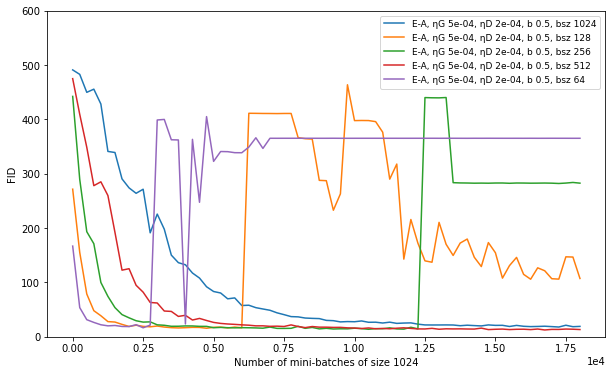

In [13]:
# cols_filter = (metrics_df['optimizer']=='ExtraAdam')& \
#                 (metrics_df['lrD']==0.0001) & \
#                 (metrics_df['lrG']==0.0005) & \
#                 (metrics_df['beta']==0.9) & \
#                 (metrics_df['loss']=="St")

cols_filter = (metrics_df['optimizer']=='ExtraAdam')& \
                (metrics_df['lrD']==0.0002) & \
                (metrics_df['lrG']==0.0005) & \
                (metrics_df['beta']==0.5) & \
                (metrics_df['loss']=="St")

batchsize_df = metrics_df[cols_filter]
batchsize_df = batchsize_df.sort_values(by=['iter'], ascending=True)

def tumbling_avg(df, max_bsz):
    cur_bsz = df['bsz'].unique()[0]
    num_of_batches = int(max_bsz/cur_bsz)
    
    count=0
    sum_fid=0
    df['avg_FID'] = -1
    
    for index, row in df.iterrows():
        count+=1
        sum_fid += row["FID"]
        if count==num_of_batches:
            df.loc[index,'avg_FID'] = sum_fid/num_of_batches
            count=0
            sum_fid=0

    return df

scaled_FID_df = batchsize_df[batchsize_df['bsz']!=1024]
scaled_FID_df = scaled_FID_df.groupby('name').apply(lambda df: tumbling_avg(df, 1024))
scaled_FID_df = scaled_FID_df[scaled_FID_df["avg_FID"]!=-1]

max_bsz_df = batchsize_df[batchsize_df['bsz']==1024]
max_bsz_df['avg_FID'] = max_bsz_df['FID']

batchsize_df = pd.concat([scaled_FID_df, max_bsz_df])
min_iter = min(batchsize_df.groupby('name').size().values)
batchsize_df = batchsize_df.groupby('name').head(min_iter)

bsz_1024_iters = list(batchsize_df[batchsize_df["bsz"]==1024]["iter"].values)

new_iter_list = []
for i in range(5):
    new_iter_list += bsz_1024_iters

batchsize_df = batchsize_df.sort_values(by=['name', 'iter'], ascending=True).assign(new_iter = new_iter_list)
batchsize_df['parameters'] = "E-A"+ \
                                ', ηG '+batchsize_df['lrG'].map(lambda x: "{:.0e}".format(x)).astype(str)+ \
                                ', ηD '+batchsize_df['lrD'].map(lambda x: "{:.0e}".format(x)).astype(str)+ \
                                ', b '+batchsize_df['beta'].astype(str)+ \
                                ', bsz '+batchsize_df['bsz'].astype(str)

# save FID figure
plt.figure(figsize=(10,6))
sns_ax = sns.lineplot(data=batchsize_df, y='FID', x='new_iter', hue='parameters')
sns_ax.legend_.set_title(None)
sns_ax.set(ylim=(0, 600))
sns_ax.legend(loc='upper right')
plt.setp(sns_ax.get_legend().get_texts(), fontsize='9');
#sns_ax.set_title("Batch size comparison for ExtraAdam");
sns_ax.set_xlabel("Number of mini-batches of size 1024");
sns_ax.set_ylabel("FID");
sns_ax.ticklabel_format(style='sci', scilimits=(0,0), axis='x')
plt.savefig('./figures/batch_size_comparison_ExtraAdam_FID.png', bbox_inches='tight', dpi=200)
plt.savefig('./figures/batch_size_comparison_ExtraAdam_FID.eps', bbox_inches='tight', format='eps')

--------------------->IGNORE<--------------------------

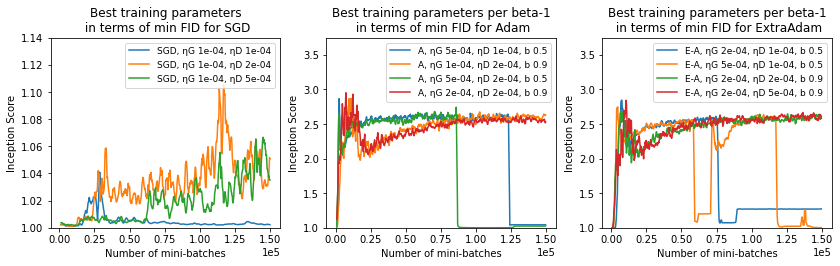

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(14, 3.5))

ax0 = sns.lineplot(data=sgd_optimizer_df, y='roll_IS_mean', x='iter', hue='parameters', ax=ax[0])
ax0.legend_.set_title(None)
ax0.legend(loc='upper right')
ax0.set(ylim=(1, 1.14))
plt.setp(ax0.get_legend().get_texts(), fontsize='9')
ax0.set_xlabel("Number of mini-batches")
ax0.set_ylabel("Inception Score")
ax0.set_title("Best training parameters\n in terms of min FID for SGD");
ax0.ticklabel_format(style='sci', scilimits=(0,0), axis='x')

ax1 = sns.lineplot(data=adam_optimizer_df, y='roll_IS_mean', x='iter', hue='parameters', ax=ax[1])
ax1.legend_.set_title(None)
ax1.legend(loc='upper right')
ax1.set(ylim=(1, 3.75))
plt.setp(ax1.get_legend().get_texts(), fontsize='9')
ax1.set_xlabel("Number of mini-batches")
ax1.set_ylabel("Inception Score")
ax1.set_title("Best training parameters per beta-1\n in terms of min FID for Adam");
ax1.ticklabel_format(style='sci', scilimits=(0,0), axis='x')

ax2 = sns.lineplot(data=extra_adam_optimizer_df, y='roll_IS_mean', x='iter', hue='parameters', ax=ax[2])
ax2.legend_.set_title(None)
ax2.legend(loc='upper right')
ax2.set(ylim=(1, 3.75))
plt.setp(ax2.get_legend().get_texts(), fontsize='9');
ax2.set_xlabel("Number of mini-batches")
ax2.set_ylabel("Inception Score")
ax2.set_title("Best training parameters per beta-1\n in terms of min FID for ExtraAdam");
ax2.ticklabel_format(style='sci', scilimits=(0,0), axis='x')

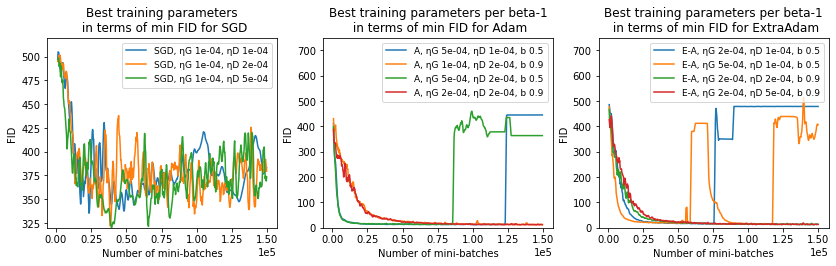

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(14, 3.5))

ax0 = sns.lineplot(data=sgd_optimizer_df, y='roll_FID', x='iter', hue='parameters', ax=ax[0])
ax0.legend_.set_title(None)
ax0.legend(loc='upper right')
ax0.set(ylim=(320, 520))
plt.setp(ax0.get_legend().get_texts(), fontsize='9')
ax0.set_xlabel("Number of mini-batches")
ax0.set_ylabel("FID")
ax0.set_title("Best training parameters\n in terms of min FID for SGD");
ax0.ticklabel_format(style='sci', scilimits=(0,0), axis='x')

ax1 = sns.lineplot(data=adam_optimizer_df, y='roll_FID', x='iter', hue='parameters', ax=ax[1])
ax1.legend_.set_title(None)
ax1.legend(loc='upper right')
ax1.set(ylim=(0, 750))
plt.setp(ax1.get_legend().get_texts(), fontsize='9')
ax1.set_xlabel("Number of mini-batches")
ax1.set_ylabel("FID")
ax1.set_title("Best training parameters per beta-1\n in terms of min FID for Adam");
ax1.ticklabel_format(style='sci', scilimits=(0,0), axis='x')

ax2 = sns.lineplot(data=extra_adam_optimizer_df, y='roll_FID', x='iter', hue='parameters', ax=ax[2])
ax2.legend_.set_title(None)
ax2.legend(loc='upper right')
ax2.set(ylim=(0, 750))
plt.setp(ax2.get_legend().get_texts(), fontsize='9');
ax2.set_xlabel("Number of mini-batches")
ax2.set_ylabel("FID")
ax2.set_title("Best training parameters per beta-1\n in terms of min FID for ExtraAdam");
ax2.ticklabel_format(style='sci', scilimits=(0,0), axis='x')